# Importing Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import spacy
import torch
import random
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix, plot_confusion_matrix
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import networkx as nx
import logging
import warnings

# Set up logging and warning filters
warnings.simplefilter("ignore")
logging.captureWarnings(True)
logging.getLogger("py.warnings").setLevel(logging.ERROR)


In [2]:
# Set global variables
TWEETS_DATA = 'user_tweets.csv'
HASHTAG_DATA = 'user_hashtag.csv'

# Functions

In [3]:
def tokenize_text(text):
    """Tokenize the text into individual words or tokens.
    """
    
    return word_tokenize(text)

def remove_stopwords(tokens):
    """Remove common words with little semantic value (stopwords).
    """
    
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    
    return filtered_tokens

def lemmatize_text(tokens):
    """Reduce words to their base form using lemmatization.
    """
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

def reading_data_to_dataframe(data):
    """Read data into a pandas DataFrame.
    """
    
    data = pd.read_csv(data, low_memory=False)
    
    return data

def clean_tweet_text(text):
    """Clean tweet text by removing aliases, emojis, unwanted characters, and "RT" pattern.
    """
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'RT\s', '', text)
    aliases = re.findall(r'@\w+', text)
    
    for alias in aliases:
        text = re.sub(r'\b\w*{}\w*\b'.format(alias[1:]), '', text)
        
    text = text.encode('ascii', 'ignore').decode('utf-8')
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = text.lower()

    tokens = tokenize_text(text)
    tokens = remove_stopwords(tokens)
    lemmatized_tokens = lemmatize_text(tokens)
    
    cleaned_text = ' '.join(lemmatized_tokens)
    
    return cleaned_text

def rename_columns(data):
    """Rename columns of a DataFrame for standardization.
    """
    
    columns = data.columns.tolist()
    new_columns = [column.lower().replace(' ', '_') for column in columns]
    
    data.columns = new_columns
    return data

def get_bow_representation(data):
    """Convert cleaned tokens into a Bag-of-Words representation.
    """
    
    vectorizer = CountVectorizer()
    bow_matrix = vectorizer.fit_transform(data['tweet'])
    bow_df = pd.DataFrame(bow_matrix.toarray(), columns=vectorizer.get_feature_names_out())
    
    return bow_df

def generate_word_embeddings(sentences):
    """Generate Word2Vec word embeddings from the given sentences.
    """
    
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    
    return model

def generate_transformer_embeddings(sentences, batch_size):
    """Generate transformer-based embeddings using a pre-trained model.
    """
    
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased')
    embeddings = []

    for i in range(0, len(sentences), batch_size):
        batch_sentences = sentences[i:i + batch_size]
        encoded_inputs = tokenizer(batch_sentences, padding=True, truncation=True, return_tensors='pt', max_length=512)
        input_ids = encoded_inputs['input_ids']
        attention_mask = encoded_inputs['attention_mask']
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
        embeddings.append(batch_embeddings)

    embeddings = np.concatenate(embeddings, axis=0)
    
    return embeddings

def apply_clustering(data, embeddings):
    """Apply K-means clustering on the transformer embeddings.
    """
    
    kmeans = KMeans(n_clusters=5)  
    kmeans.fit(embeddings)

    cluster_labels = kmeans.labels_
    data['label'] = cluster_labels
    
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x='label')
    plt.title('Cluster Distribution')
    plt.xlabel('Cluster Label')
    plt.ylabel('Count')
    plt.show()

    return data

def train_classifier(embeddings, labels):
    """Train a classifier using the transformer embeddings to predict tweet labels.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    return classifier, accuracy

def perform_similarity_search(query_tweet, data, embeddings):
    """Perform similarity-based search using the query tweet and transformer embeddings.
    """
    
    query_embedding = generate_transformer_embeddings([query_tweet], batch_size)[0]
    similarities = cosine_similarity(query_embedding.reshape(1, -1), embeddings)
    most_similar_indices = similarities.argsort()[0][-5:]
    similar_tweets = data.loc[most_similar_indices, 'tweet']
    
    return similar_tweets

def perform_named_entity_recognition(data):
    """Perform named entity recognition on tweets using transformer embeddings.
    """
    
    nlp = spacy.load('en_core_web_sm')
    named_entities = []
    
    for tweet in data['tweet']:
        doc = nlp(tweet)
        entities = [ent.text for ent in doc.ents]
        named_entities.append(entities)
    data['named_entities'] = named_entities
    
    return data

def generate_sentiment(data):
    """Generate sentiment labels for tweets using VADER sentiment analysis.
    """
    
    sia = SentimentIntensityAnalyzer()
    
    def get_sentiment_polarity(score):
        if score >= 0.05:
            return "Positive"
        elif score <= -0.05:
            return "Negative"
        else:
            return "Neutral"
        
    data['sentiment'] = data['tweet'].apply(lambda x: get_sentiment_polarity(sia.polarity_scores(x)['compound']))
    
    return data

def train_sentiment_analysis_model(embeddings, labels):
    """Train a sentiment analysis model using the transformer embeddings.
    """
    
    X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2)
    sentiment_model = RandomForestClassifier()
    
    sentiment_model.fit(X_train, y_train)
    y_pred = sentiment_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print("Classification Report:")
    print(report)
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()
    
    cv_scores = cross_val_score(sentiment_model, embeddings, labels, cv=5)
    print("Cross-Validation Scores:", cv_scores)
    
    return sentiment_model, accuracy, report, cm, cv_scores


def generate_word_cloud(data):
    """Most used words from the tweets that has been extracted
    """
    
    text = ' '.join(data['tweet'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    
def draw_network_graph(hashtag_df, transformer_embeddings, sample_size, threshold):
    """Network diagram of the tweets and its connection with other user's tweets
    """
    
    sample_tweets = random.sample(hashtag_df['tweet'].tolist(), sample_size)
    graph = nx.Graph()
    
    for tweet in sample_tweets:
        graph.add_node(tweet)

    for i in range(len(sample_tweets)):
        for j in range(i + 1, len(sample_tweets)):
            tweet1 = sample_tweets[i]
            tweet2 = sample_tweets[j]
            similarity = cosine_similarity(
                transformer_embeddings[i].reshape(1, -1),
                transformer_embeddings[j].reshape(1, -1)
            )
            if similarity > threshold:
                graph.add_edge(tweet1, tweet2)

    handles_dict = hashtag_df.set_index('tweet')['twitter_handle'].to_dict()
    labels = {tweet: handles_dict.get(tweet, '') for tweet in sample_tweets}

    degree_centrality = nx.degree_centrality(graph)    
    node_colors = [degree_centrality[node] for node in graph.nodes()]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.1)
    nx.draw_networkx_nodes(graph, pos, node_size=50, node_color=node_colors, cmap=plt.cm.Set1)
    nx.draw_networkx_edges(graph, pos, alpha=0.2)
    nx.draw_networkx_labels(graph, pos, labels, font_size=8)
    plt.title("Network Graph of Sampled Tweets")
    plt.axis('off')
    plt.show()

    return

# Main 

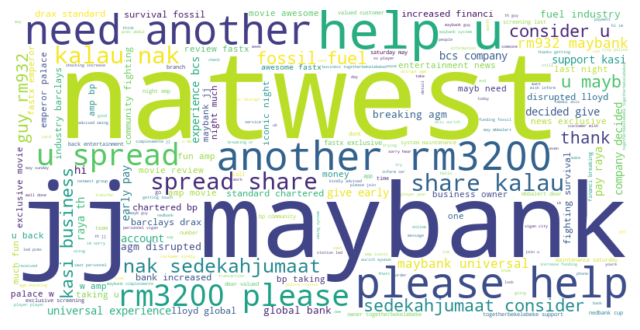

In [4]:
# Read data into a DataFrame
hashtag_df = reading_data_to_dataframe(data=HASHTAG_DATA)

# Clean tweet text
hashtag_df['Tweet'] = hashtag_df['Tweet'].apply(lambda x: clean_tweet_text(x))

# Rename columns
hashtag_df = rename_columns(data=hashtag_df)

# Generates word cloud diagram, most common words from tweets
wordcloud = generate_word_cloud(hashtag_df)

# Get Bag-of-Words representation
bow_representation = get_bow_representation(data=hashtag_df)

# Generate Word2Vec word embeddings
sentences = [tweet.split() for tweet in hashtag_df['tweet']]
word_embeddings_model = generate_word_embeddings(sentences)
word_embedding = word_embeddings_model.wv['word']

In [5]:
# Generate transformer embeddings
batch_size = 32
sentences = hashtag_df['tweet'].tolist()
transformer_embeddings = generate_transformer_embeddings(sentences, batch_size)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


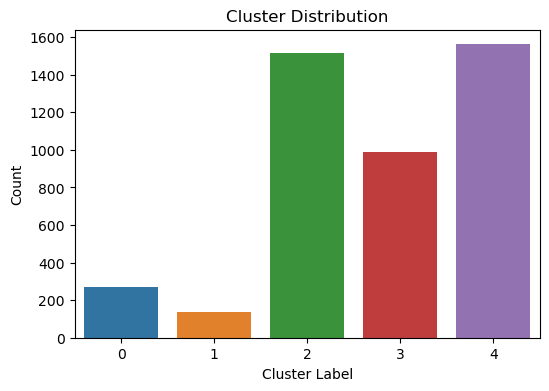

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
# Applies clustering for the transformer embeddings
hashtag_df = apply_clustering(hashtag_df, transformer_embeddings)

# Trains the transformer embeddings
classifier, accuracy = train_classifier(transformer_embeddings, hashtag_df['label'])

# Perform similarity-based search using the query tweet and transformer embeddings
query_tweet = "man"
similar_tweets = perform_similarity_search(query_tweet, hashtag_df, transformer_embeddings)

# Print the similar tweets
# print("Similar Tweets:")
# print(similar_tweets)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.98      0.65      0.78       190
     Neutral       0.84      0.58      0.69       177
    Positive       0.80      0.98      0.88       528

    accuracy                           0.83       895
   macro avg       0.87      0.74      0.78       895
weighted avg       0.85      0.83      0.82       895



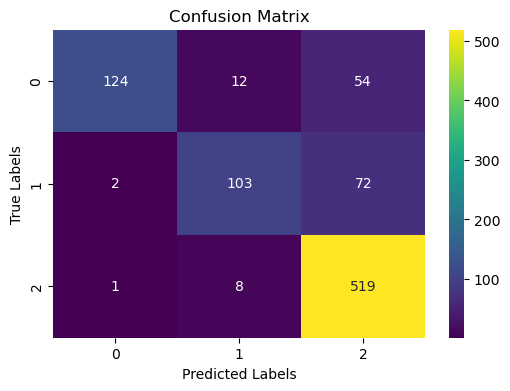

Cross-Validation Scores: [0.8424581  0.76312849 0.81117318 0.70949721 0.66256983]


In [7]:
# Perform named entity recognition 
hashtag_df = perform_named_entity_recognition(hashtag_df)

# Generate sentiment if it's +- or neutral
hashtag_df = generate_sentiment(data=hashtag_df)

# Model's output 
sentiment_model, accuracy, report, cm, cv_scores = train_sentiment_analysis_model(transformer_embeddings, hashtag_df['sentiment'])

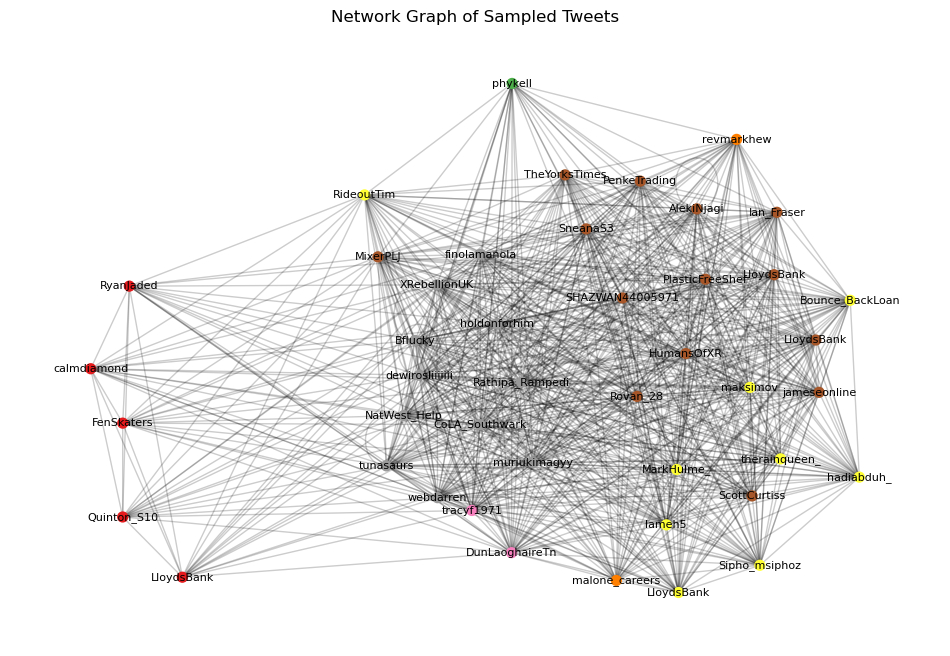

In [8]:
sample_size = 60
threshold = 0.80
# Call the function to draw the network graph
draw_network_graph(hashtag_df, transformer_embeddings, sample_size, threshold)

In [9]:
#To modify -> 
# 1) When scrapping, add the hashtag column, for instance if looking for #natwest, then create col in the df['hashtag'] = 'natwest'...will be useful for visuals
# 2) Convert the tweets to a single language (english)
# 3) Make changes to the transformer embeddings and algorithm used (requires high computation power)

In [10]:
# Next tasks is to play around with user_tweets.csv datasets